In [7]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

In [22]:
# read income and efficiency data
ic_in = pd.read_csv(Path('analysis_data/income_cats.csv'), index_col=0, header=None)
ef_in = pd.read_csv(Path('analysis_data/eff_io.csv'), index_col=0)

# concat into one dataframe
eff = pd.concat((ic_in, ef_in), axis=1)
eff.columns = ['income',*eff.columns[1:]]
inc = eff['income'].unique()

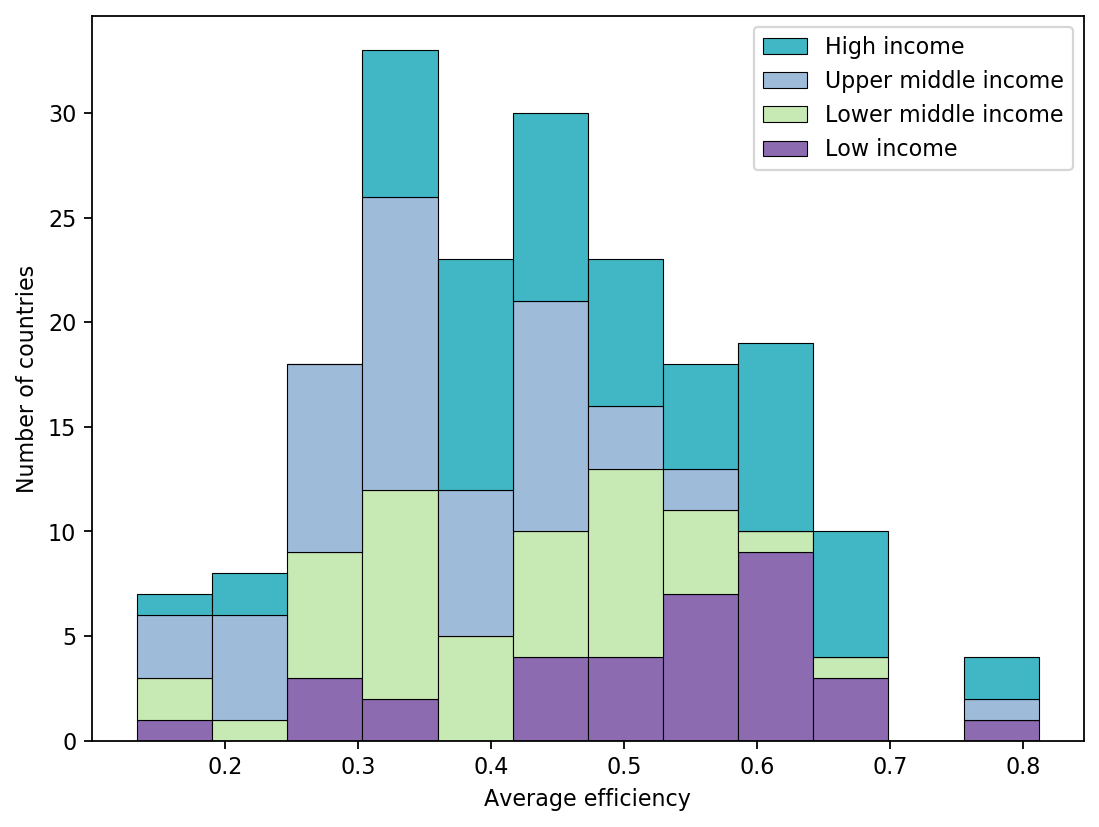

In [51]:
# histogram of average efficies across SDGs, stacked by income category

cmap = np.divide([[140,107,177],
                 [199,233,180],
                 [158,188,218],
                 [65,182,196]],255)
nbins = 12
fig = plt.figure(num=None, figsize=(8, 6), dpi=160, facecolor='w', edgecolor='k')
ax = fig.add_subplot(1, 1, 1)
plt.hist([eff[eff['income']==ii].iloc[:,1:].mean(axis=1) for ii in inc], bins = nbins, stacked=True, color=cmap, label=inc, edgecolor='k', linewidth=0.5, zorder=2)

plt.xlabel('Average efficiency')
plt.ylabel('Number of countries')
plt.legend()

# reverse legend order
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[::-1], ['High income', 'Upper middle income', 'Lower middle income', 'Low income'])